## 1. IMDB intro

IMDB는 영화에 대한 여러 정보를 제공하는 웹사이트입니다. 이 웹사이트에서 작성된 리뷰들은 감정분석에서 사용되는 대표적인 데이터셋으로 유명하죠.

이번 과제에서는 Kaggle의 Bag of Words Meets Bags of Popcorn이라는 **감성분석** 튜토리얼을 진행해볼 것입니다.

참고: https://www.kaggle.com/competitions/word2vec-nlp-tutorial/overview

지난 예습과제에서는 한국어 데이터를 만져보았다면, 이번 데이터는 영어 데이터입니다. 두 언어 간 차이로 인해 전처리 과정에서도 미묘한 차이가 존재합니다.

주어지는 데이터셋은 train set과 test set 모두 25,000개의 긍정 부정 리뷰로 구성되어 있으며, 긍정인 경우엔 label이 1이고, 부정인 경우엔 label이 0입니다.

## 2. Load Files

구글 드라이브에 다운받은 파일을 저장하고, 파일을 불러온다.

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
import pandas as pd
from bs4 import BeautifulSoup
from nltk.stem import WordNetLemmatizer
import re
import nltk
from nltk.corpus import stopwords
nltk.download('stopwords')
from nltk.stem import PorterStemmer
nltk.download('wordnet')
nltk.download('omw-1.4')
from nltk.stem import WordNetLemmatizer
import matplotlib as plt

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data] Downloading package omw-1.4 to /root/nltk_data...


In [3]:
p = "/content/drive/MyDrive/24-1NLP/Week2/"
train = pd.read_csv(p + 'labeledTrainData.tsv', header=0, delimiter='\t', quoting=3)
test = pd.read_csv(p + 'testData.tsv', header=0, delimiter='\t', quoting=3)
submit = pd.read_csv(p + 'sampleSubmission.csv')



---



## 3. 간략한 데이터 탐색

In [4]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 25000 entries, 0 to 24999
Data columns (total 3 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   id         25000 non-null  object
 1   sentiment  25000 non-null  int64 
 2   review     25000 non-null  object
dtypes: int64(1), object(2)
memory usage: 586.1+ KB


In [5]:
train.head()

,id,sentiment,review
0,"""5814_8""",1,"""With all this stuff going down at the moment ..."
1,"""2381_9""",1,"""\""The Classic War of the Worlds\"" by Timothy ..."
2,"""7759_3""",0,"""The film starts with a manager (Nicholas Bell..."
3,"""3630_4""",0,"""It must be assumed that those who praised thi..."
4,"""9495_8""",1,"""Superbly trashy and wondrously unpretentious ..."


In [6]:
test.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 25000 entries, 0 to 24999
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   id      25000 non-null  object
 1   review  25000 non-null  object
dtypes: object(2)
memory usage: 390.8+ KB


In [7]:
test.head()

,id,review
0,"""12311_10""","""Naturally in a film who's main themes are of ..."
1,"""8348_2""","""This movie is a disaster within a disaster fi..."
2,"""5828_4""","""All in all, this is a movie for kids. We saw ..."
3,"""7186_2""","""Afraid of the Dark left me with the impressio..."
4,"""12128_7""","""A very accurate depiction of small time mob l..."


긍정, 부정 label은 각각 12,500개로 동일하다는 것을 알 수 있습니다.

In [8]:
train['sentiment'].value_counts()

1    12500
0    12500
Name: sentiment, dtype: int64

## 4. Text Preprocessing

### 4-1. html 태그 제거
첫번째 review를 보면 특이점이 있습니다. 바로 `<br>`이라는 html 줄바꿈 태그가 보인다는 점입니다. 첫번째 review뿐만 아니라 다른 review들에도 이러한 태그가 존재할 가능성이 있습니다. 따라서 `BeautifulSoup`를 이용하여 분석에 방해가 되는 태그들은 지워주도록 합시다.

In [9]:
train["review"][0]

'"With all this stuff going down at the moment with MJ i\'ve started listening to his music, watching the odd documentary here and there, watched The Wiz and watched Moonwalker again. Maybe i just want to get a certain insight into this guy who i thought was really cool in the eighties just to maybe make up my mind whether he is guilty or innocent. Moonwalker is part biography, part feature film which i remember going to see at the cinema when it was originally released. Some of it has subtle messages about MJ\'s feeling towards the press and also the obvious message of drugs are bad m\'kay.<br /><br />Visually impressive but of course this is all about Michael Jackson so unless you remotely like MJ in anyway then you are going to hate this and find it boring. Some may call MJ an egotist for consenting to the making of this movie BUT MJ and most of his fans would say that he made it for the fans which if true is really nice of him.<br /><br />The actual feature film bit when it finally

In [10]:
from bs4 import BeautifulSoup

위 리뷰를 soup 객체로 바꿔주면, html 태그를 제외하고 text만 온전히 추출하는 작업이 가능합니다. 이 기능을 해주는 것이 `get_text()`입니다. 첫번째 리뷰를 하나의 예시로 들어봅시다. 윗문장이 제거 전, 아래문장이 제거 후입니다.


In [11]:
example1 = BeautifulSoup(train["review"][0])
example1 = example1.get_text()
print("before deleting:", train['review'][0])
print("after deleting:", example1)

before deleting: "With all this stuff going down at the moment with MJ i've started listening to his music, watching the odd documentary here and there, watched The Wiz and watched Moonwalker again. Maybe i just want to get a certain insight into this guy who i thought was really cool in the eighties just to maybe make up my mind whether he is guilty or innocent. Moonwalker is part biography, part feature film which i remember going to see at the cinema when it was originally released. Some of it has subtle messages about MJ's feeling towards the press and also the obvious message of drugs are bad m'kay.<br /><br />Visually impressive but of course this is all about Michael Jackson so unless you remotely like MJ in anyway then you are going to hate this and find it boring. Some may call MJ an egotist for consenting to the making of this movie BUT MJ and most of his fans would say that he made it for the fans which if true is really nice of him.<br /><br />The actual feature film bit wh

### 4-2. 정규표현식(re)으로 알파벳만 남기기

html 태그는 제거했지만, 각종 특수문자가 아직도 남아있습니다. 이는 분석에 불필요한 정보입니다. 알파벳만 남기고 싶다면 정규표현식(regular expression)을 사용하면 됩니다.

'알파벳이 아닌 것'을 '공백'으로 대체하면 될 것입니다. 이러한 기능을 가진 함수는 `re.sub(대체할 패턴, 대체 이후, 대체할 범위)`입니다.

아래 정규표현식에서 쓰인 `^`은 not의 의미입니다. `a-z`는 소문자 전체를 뜻하고, `A-Z`는 대문자 전체를 뜻합니다. 즉, `letters_only`의 output은 *example1에서* 알파벳 대소문자가 아닌 것을 공백으로 바꾼 형태가 될 것입니다.

In [12]:
import re
letters_only = re.sub("[^a-zA-Z]", ' ', example1)

In [13]:
train['review'][0]

'"With all this stuff going down at the moment with MJ i\'ve started listening to his music, watching the odd documentary here and there, watched The Wiz and watched Moonwalker again. Maybe i just want to get a certain insight into this guy who i thought was really cool in the eighties just to maybe make up my mind whether he is guilty or innocent. Moonwalker is part biography, part feature film which i remember going to see at the cinema when it was originally released. Some of it has subtle messages about MJ\'s feeling towards the press and also the obvious message of drugs are bad m\'kay.<br /><br />Visually impressive but of course this is all about Michael Jackson so unless you remotely like MJ in anyway then you are going to hate this and find it boring. Some may call MJ an egotist for consenting to the making of this movie BUT MJ and most of his fans would say that he made it for the fans which if true is really nice of him.<br /><br />The actual feature film bit when it finally

In [14]:
letters_only

' With all this stuff going down at the moment with MJ i ve started listening to his music  watching the odd documentary here and there  watched The Wiz and watched Moonwalker again  Maybe i just want to get a certain insight into this guy who i thought was really cool in the eighties just to maybe make up my mind whether he is guilty or innocent  Moonwalker is part biography  part feature film which i remember going to see at the cinema when it was originally released  Some of it has subtle messages about MJ s feeling towards the press and also the obvious message of drugs are bad m kay Visually impressive but of course this is all about Michael Jackson so unless you remotely like MJ in anyway then you are going to hate this and find it boring  Some may call MJ an egotist for consenting to the making of this movie BUT MJ and most of his fans would say that he made it for the fans which if true is really nice of him The actual feature film bit when it finally starts is only on for    m

### 4-3. 토큰화(Tokenizing)

토큰(token)은 의미를 갖는 최소 분석 단위입니다. **토큰화(tokenizing)** 는 corpus 덩어리를 작은 토큰 단위로 쪼개어주는 작업입니다. 영어에서는 대체로 띄어쓰기를 기준으로 토큰화를 합니다.

즉 아래처럼 `split()` 함수를 써주기만 하면 띄어쓰기(단어) 단위로 토큰화가 진행될 것입니다. 아래 예시를 통해 하나의 문장에서 437개의 단어로 토큰화된 것을 확인할 수 있습니다.

`lower_case` 함수로 소문자로 변환하는 이유는 무엇일까요? 대문자와 소문자는 다른 단어로 구분되기에 이를 그대로 두면 복잡성을 야기할 수 있습니다. 따라서 단어집합 크기를 최대한 줄이기 위해 대소문자를 통합하는 것입니다.

물론 무작정 소문자로 통합하는 것도 지양해야하는 것이, 미국을 뜻하는 US와 우리를 뜻하는 us는 엄밀히 다르기 때문입니다.

In [15]:
lower_case = letters_only.lower()
token_words = lower_case.split()
print("토큰화 이후 생성된 토큰(단어) 개수: ",len(token_words))

토큰화 이후 생성된 토큰(단어) 개수:  437


참고) nltk와 케라스에서 토큰화를 수행해주는 도구들을 제공합니다. 이 도구들은 아포스트로피가 들어간 단어들을 지혜롭게 토큰화해줍니다. 본 과제에서는 앞서 정규표현식으로 아포스트로피를 모두 제거했기에 굳이 아래 도구들을 사용하지 않고 `split()`로만 토큰화를 수행했습니다.

In [16]:
# from nltk.tokenize import word_tokenize
# word_tokenize(lower_case)
# from nltk.tokenize import WordPunctTokenizer
# WordPunctTokenizer().tokenize(lower_case)
# from tensorflow.keras.preprocessing.text import text_to_word_sequence
# text_to_word_sequence(lower_case)

### 4-4. 불용어(Stopword) 제거

단어를 기준으로 토큰화를 완료했습니다. 이제 이 단어들 중에서 무의미한 것들을 제거하는 작업이 필요합니다. 예컨대 I, we, you, our 등 굉장히 자주 등장하지만 분석에서 크게 중요하지 않은 단어들을 무의미한 단어로 볼 수 있습니다.

이처럼 무의미한 단어들을 **불용어(Stopword)** 라고 부릅니다.

`nltk`에서는 영어의 불용어들을 제공해줍니다. 내장된 불용어의 개수는 179개입니다. 예시 리뷰에서 이 불용어들을 제거해주고 나니 437개였던 토큰이 219개로 확 줄어들었습니다.

In [17]:
import nltk
nltk.download("stopwords")

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

In [18]:
from nltk.corpus import stopwords
stopwords_list = stopwords.words('english')
print("nltk에 내장된 불용어 개수: ", len(stopwords_list))
print("불용어 예시: ", stopwords_list[:10])
non_stopwords = [w for w in token_words if not w in stopwords_list]
print("예시 review에서 불용어 제거하고 남은 토큰 개수: ",len(non_stopwords))

nltk에 내장된 불용어 개수:  179
불용어 예시:  ['i', 'me', 'my', 'myself', 'we', 'our', 'ours', 'ourselves', 'you', "you're"]
예시 review에서 불용어 제거하고 남은 토큰 개수:  219


### 4-5. 어간 추출(Stemming)

nltk에선 단어에서 어간을 추출해주는 도구를 제공합니다. 하지만 이 어간 추출의 작업은 정확히 어간만 추출하는 것이 아니라 정해진 규칙에 따라 임의로 어미를 떼어놓는 작업이기에 100% 정확하게 어간만 추출하지는 못합니다.

nltk의 포터 알고리즘의 규칙은 다음과 같습니다.
- ALIZE → AL
- ANCE → 제거
- ICAL → IC

이라는 규칙에 따라 어간을 추출합니다.

예시를 들어보면, 아래와 같은 어간 추출을 합니다.

- formalize → formal
- allowance → allow
- electricical → electric

출처: 딥러닝을 이용한 자연어 처리 입문 위키독스(https://wikidocs.net/21707)

In [19]:
from nltk.stem import PorterStemmer
porter_stemmer = PorterStemmer()
stemmed_words = [porter_stemmer.stem(w) for w in non_stopwords]

### 4-6. 표제어 추출(Lemmatization)

표제어 추출도 어간 추출과 마찬가지의 역할을 수행한다. 이 둘은 본질적인 차이를 갖는데, Stemming은 단어 그 자체만을 고려하지만 Lemmatization은 그 단어가 문장 속에서 어떤 품사(Part-of-speech)로 쓰였는지까지 판단한다는 점이다. 따라서 Lemmatization이 보다 복잡한 처리 과정을 거칠 수밖에 없다.

kaggle의 다른 여러 코드들을 참고한 결과 stemming을 하는 것보다 lemmatization을 하는 것이 더 나은 결과를 도출하는 것 같아서 lemmatization만 수행하도록 하겠다.

In [20]:
nltk.download('wordnet')
nltk.download('omw-1.4')
from nltk.stem import WordNetLemmatizer
wordnet_lemmatizer = WordNetLemmatizer()

[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package omw-1.4 to /root/nltk_data...
[nltk_data]   Package omw-1.4 is already up-to-date!


In [21]:
lemmatized_words = [wordnet_lemmatizer.lemmatize(w) for w in non_stopwords]
lemmatized_words = [wordnet_lemmatizer.lemmatize(w,"v") for w in lemmatized_words]

In [22]:
print(non_stopwords[21:40]) # none
print(stemmed_words[21:40]) # stemming
print(lemmatized_words[21:40]) # lemmatization

['really', 'cool', 'eighties', 'maybe', 'make', 'mind', 'whether', 'guilty', 'innocent', 'moonwalker', 'part', 'biography', 'part', 'feature', 'film', 'remember', 'going', 'see', 'cinema']
['realli', 'cool', 'eighti', 'mayb', 'make', 'mind', 'whether', 'guilti', 'innoc', 'moonwalk', 'part', 'biographi', 'part', 'featur', 'film', 'rememb', 'go', 'see', 'cinema']
['really', 'cool', 'eighty', 'maybe', 'make', 'mind', 'whether', 'guilty', 'innocent', 'moonwalker', 'part', 'biography', 'part', 'feature', 'film', 'remember', 'go', 'see', 'cinema']


### 4-7. 하나의 함수로 표현

앞선 6가지의 전처리 과정을 하나의 함수로 통합합니다.

In [23]:
stopwords_list = set(stopwords.words('english'))
wordnet_lemmatizer = WordNetLemmatizer()

def review_to_words(raw_review):
  except_tag = BeautifulSoup(raw_review).get_text() # html 태그 제거
  letters_only = re.sub("[^a-zA-Z]", " ", except_tag) # 알파벳만 남기기
  token_words = letters_only.lower().split() # 소문자로 통합하고 단어 단위로 토큰화(띄어쓰기 단위 split)
  non_stopwords = [w for w in token_words if not w in stopwords_list] # 불용어 삭제
  lemmatized_words = [wordnet_lemmatizer.lemmatize(w) for w in non_stopwords]
  lemmatized_words = [wordnet_lemmatizer.lemmatize(w,"v") for w in lemmatized_words] # Lemmatization
  words = " ".join(lemmatized_words)
  return words



---



## 5. BoW(Bag of Words) 형태로 변환

Bag of words는 단어의 출현 빈도에 집중하여 텍스트를 수치화하는 표현 방식입니다.

예를 들어 아래처럼 두 개의 노래 구절이 있는 경우

```python
lyric1 = "but I don't want to stay in the middle"
lyric2 = "like you a little don't want no riddle"
```

아래 같은 단어 모음이 만들어지고

```python
vocab = ["but", "I", "don't", "want", "to", "stay", "in", "the", "middle", "like", "you", "a", "little", "no", "riddle"]
```

아래처럼 단어들을 빈도로 수치화할 수 있습니다.

```python
lyric1 = [1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0]
lyric2 = [0, 0, 1, 1, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1]
```


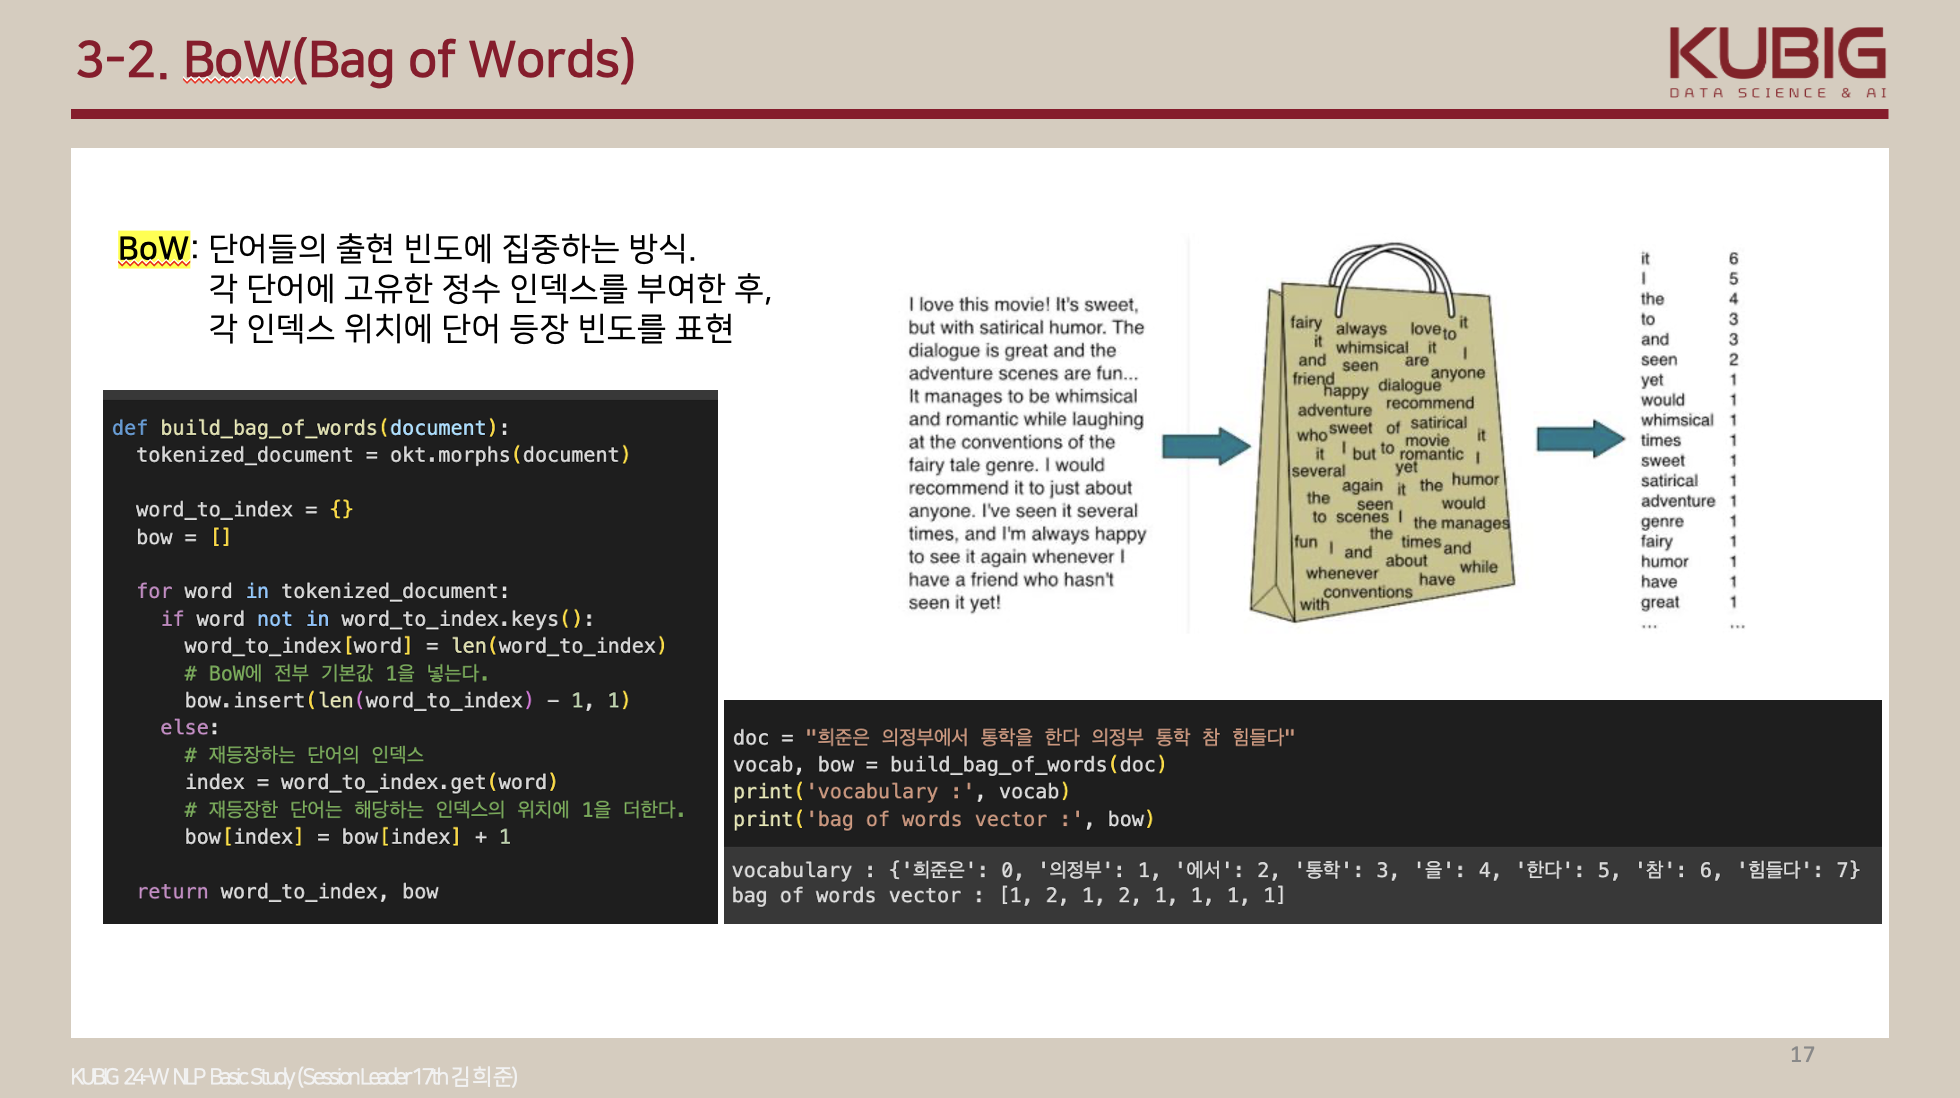


위 같은 작업을 사이킷런의 `CountVectorizer`가 수행해줍니다.

In [24]:
train['review']

0        "With all this stuff going down at the moment ...
1        "\"The Classic War of the Worlds\" by Timothy ...
2        "The film starts with a manager (Nicholas Bell...
3        "It must be assumed that those who praised thi...
4        "Superbly trashy and wondrously unpretentious ...
                               ...                        
24995    "It seems like more consideration has gone int...
24996    "I don't believe they made this film. Complete...
24997    "Guy is a loser. Can't get girls, needs to bui...
24998    "This 30 minute documentary Buñuel made in the...
24999    "I saw this movie as a child and it broke my h...
Name: review, Length: 25000, dtype: object

In [25]:
num_reviews = train['review'].size

# clean_train_reviews = list(map(lambda x: review_to_words(x), train['review']))
clean_train_reviews = []
for i in range(0, num_reviews):
     if (i + 1) % 5000 == 0 :  #실행이 잘되는지 확인하기 위해 5000개 실행될때마다 확인문구
         print('Review {} of {}'.format(i+1, num_reviews))
     clean_train_reviews.append(review_to_words(train['review'][i]))

<ipython-input-23-f98c913dc02a>:5: MarkupResemblesLocatorWarning: The input looks more like a filename than markup. You may want to open this file and pass the filehandle into Beautiful Soup.
  except_tag = BeautifulSoup(raw_review).get_text() # html 태그 제거


Review 5000 of 25000
Review 10000 of 25000
Review 15000 of 25000
Review 20000 of 25000
Review 25000 of 25000


`clean_train_reviews`에는 25,000개의 전처리된 리뷰들이 담겨있습니다. 이것을 `CountVectorizer에` input으로 넣어주면 BoW가 완성됩니다.

In [26]:
from sklearn.feature_extraction.text import CountVectorizer

vectorizer = CountVectorizer(analyzer = 'word', # 학습 단위
                             tokenizer = None,
                             preprocessor = None,
                             stop_words = None,
                             min_df = 2, # 토큰이 나타날 최소 문서 개수
                             ngram_range=(1, 2), # 단어의 묶음 개수
                             max_features = 4000) # 토큰의 최대 개수, 즉 컬럼의 최대 개수

### 참고) TfidfVectorizer

이번엔 `CounterVectorizer`보다 한 단계 나아간 `TidfVectorizer`에 대해 살펴볼 것입니다.

`TidfVectorizer()`는 TF-IDF(단어빈도*문서빈도역수)를 학습시키는 함수입니다. 단어빈도란 특정 단어가 한 문서 내에서 출현한 빈도이고, 문서빈도는 특정 단어가 출현한 전체 문서의 개수입니다.

왜 두 빈도를 모두 알아야 할까요? 예컨대 정관사 a, the는 영어에서 굉장히 많이 쓰입니다. 하지만 출현빈도에 비해 그렇게 중요치 않은 단어입니다. 이처럼 단어빈도는 높아도 중요도가 낮은 단어들을 걸러주기 위해 이 단어가 출현한 문서의 빈도도 카운트해줄 필요가 있다는 얘기입니다.

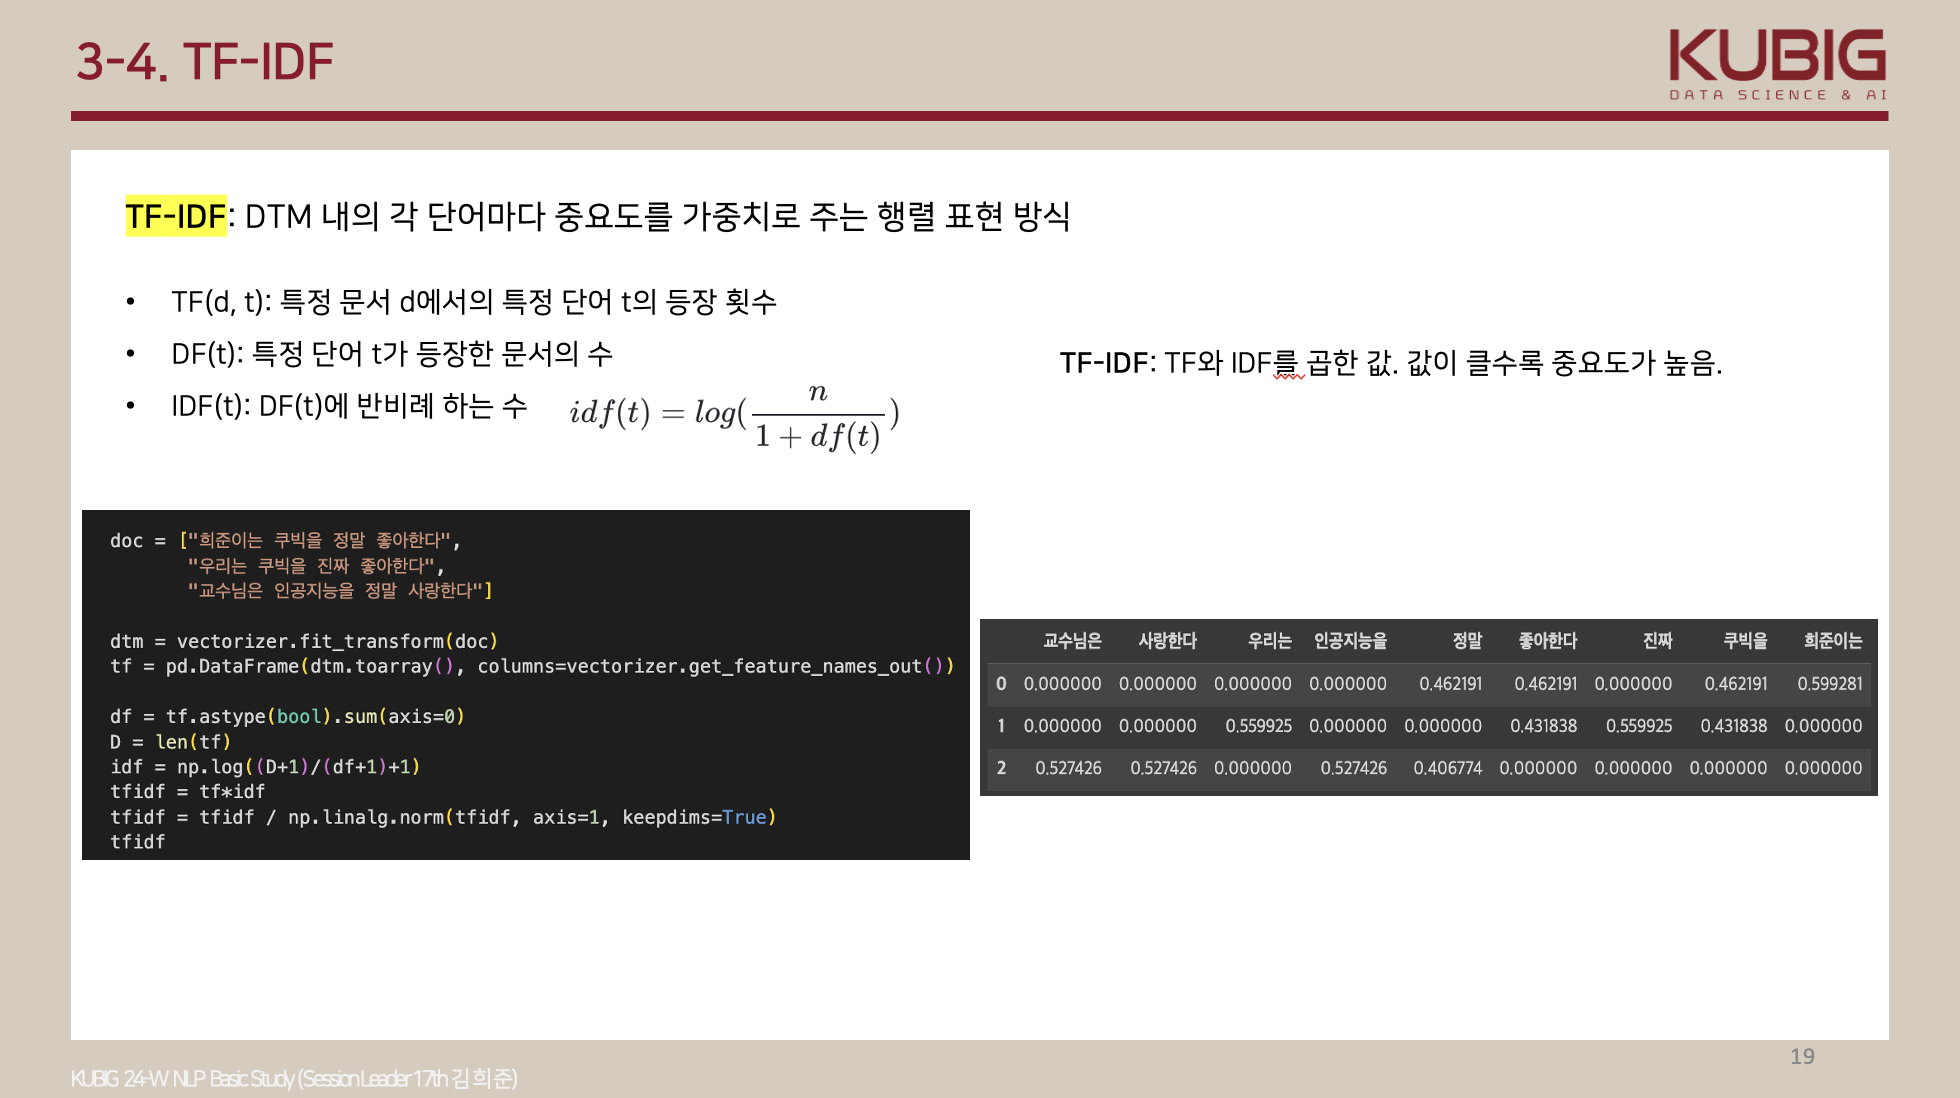

In [27]:
from sklearn.feature_extraction.text import TfidfVectorizer

vectorizer = TfidfVectorizer(min_df = 4, # 토큰이 나타날 최소 문서 개수
                             analyzer = 'word', # 학습 단위
                             ngram_range = (1, 2), # 단어의 묶음 개수
                             max_features = 1000) # 토큰의 최대 개수, 즉 컬럼의 최대 개수

In [28]:
train_data_features = vectorizer.fit_transform(clean_train_reviews)
train_data_features.shape

(25000, 1000)

`TfidfVectorizer`의 `get_feature_names()` 메서드로 토큰 이름들을 추출할 수 있습니다.**굵은 텍스트**

In [29]:
vocab = vectorizer.get_feature_names_out() # sklearn 0.24< : get_feature_names() -> get_feature_names_out()
vocab[:10]

array(['ability', 'able', 'absolutely', 'accent', 'accept', 'across',
       'act', 'action', 'actor', 'actress'], dtype=object)

## 7. Modeling

baseline 코드로 제시된 트리 계열 알고리즘으로 학습을 시켜봅니다.

원하시는 경우 성능 향상을 위해 새롭게 코드를 짜보셔도 좋습니다!

In [30]:
from sklearn.ensemble import RandomForestClassifier
from lightgbm import LGBMClassifier
from xgboost import XGBClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_auc_score
from sklearn.ensemble import StackingClassifier
from sklearn.linear_model import LogisticRegression

x = train_data_features
y = train['sentiment']

x_train, x_val, y_train, y_val = train_test_split(x, y, test_size=0.3, random_state=42)

# 트리 알고리즘 3개를 사용
rf = RandomForestClassifier(n_estimators = 200,
                            n_jobs = -1,
                            random_state=42,
                            max_depth=20)

xgb = XGBClassifier(n_estimators=200,
                    max_depth=10,
                    learning_rate=0.05,
                    objective='binary:logistic')

lgbm = LGBMClassifier(n_estimators=200,
                    max_depth=10,
                    metric='binary_logloss')

In [31]:
xgb.fit(x_train, y_train)
y_pred_xgb = xgb.predict_proba(x_val)

In [32]:
lgbm.fit(x_train, y_train)
y_pred_lgbm = lgbm.predict_proba(x_val)

[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Info] Number of positive: 8738, number of negative: 8762
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.135413 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 197823
[LightGBM] [Info] Number of data points in the train set: 17500, number of used features: 1000
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.499314 -> initscore=-0.002743
[LightGBM] [Info] Start training from score -0.002743
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).


In [33]:
rf.fit(x_train, y_train)
y_pred_rf = rf.predict_proba(x_val)

학습된 모델들의 `roc_auc_score`는 아래처럼 구할 수 있다.

In [34]:
print('Random Forest AUC Score :', roc_auc_score(y_val, y_pred_rf[:,1]))
print('XGBoost AUC Score :', roc_auc_score(y_val, y_pred_xgb[:,1]))
print('LGBM AUC Score :', roc_auc_score(y_val, y_pred_lgbm[:,1]))

Random Forest AUC Score : 0.9076715878903935
XGBoost AUC Score : 0.9164858292593361
LGBM AUC Score : 0.9262710316820311


## 8. test set 추론

In [35]:
num_reviews = test['review'].size

clean_test_reviews = []
for i in range(0, num_reviews):
     if (i + 1) % 5000 == 0 :  #실행이 잘 되는지 확인하기 위해 5000개 실행될때마다 확인문구
         print('Review {} of {}'.format(i+1, num_reviews))
     clean_test_reviews.append(review_to_words(test['review'][i]))

<ipython-input-23-f98c913dc02a>:5: MarkupResemblesLocatorWarning: The input looks more like a filename than markup. You may want to open this file and pass the filehandle into Beautiful Soup.
  except_tag = BeautifulSoup(raw_review).get_text() # html 태그 제거


Review 5000 of 25000
Review 10000 of 25000
Review 15000 of 25000
Review 20000 of 25000
Review 25000 of 25000


In [36]:
test_data_features = vectorizer.fit_transform(clean_test_reviews)
test_data_features = test_data_features.toarray()

In [37]:
# 3개 알고리즘 중 원하는 것으로 predict
result = lgbm.predict(test_data_features)
submit['sentiment'] = result

[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).


In [38]:
submit.head(10)

,id,sentiment
0,12311_10,1
1,8348_2,0
2,5828_4,1
3,7186_2,1
4,12128_7,0
5,2913_8,0
6,4396_1,0
7,395_2,1
8,10616_1,0
9,9074_9,0


원하시는 분은 직접 결과 제출도 해보세요!

https://www.kaggle.com/competitions/word2vec-nlp-tutorial/submissions

In [39]:
submit.to_csv("./submission_240117.csv", index=False)